# O2O优惠券线下使用情况

https://blog.csdn.net/BiLiBa123/article/details/128020313?ops_request_misc=%257B%2522request%255Fid%2522%253A%2522168272786316800184144333%2522%252C%2522scm%2522%253A%252220140713.130102334..%2522%257D&request_id=168272786316800184144333&biz_id=0&utm_medium=distribute.pc_search_result.none-task-blog-2~all~sobaiduend~default-2-128020313-null-null.142^v86^control,239^v2^insert_chatgpt&utm_term=%E4%BC%98%E6%83%A0%E5%88%B8%E4%BD%BF%E7%94%A8%E6%83%85%E5%86%B5%E5%88%86%E6%9E%90&spm=1018.2226.3001.4187  

https://www.bilibili.com/video/BV1K24y1G7pJ?p=42

数据清洗工具：jupyter notebook

数据分析工具：Python

可视化图表工具：Pyecharts

分析类型：描述性分析，诊断分析

分析方法：漏斗分析，RFM用户价值分析，AARRR分析，假设检验分析。

## 一. 数据清洗



        1.1 数据集来源

数据来源：https://tianchi.aliyun.com/competition/entrance/231593/information

        1.2 数据说明
数据说明：用户在2016年1月1日至2016年6月30日之间真实线下消费行为数据

分析工具：Python

Table 1: 用户线下消费和优惠券领取行为

| Field | Description |  
| :--- | :--- |
| User_id | 用户ID |  
| Merchant_id | 商户ID|  
|Coupon_id | 优惠券ID：null表示无优惠券消费，此时Discount_rate和Date_received字段无意义 |
| Discount_rate | 优惠率：x \in [0,1]代表折扣率；x:y表示满x减y。单位是元 |
| Distanceuser | 经常活动的地点离该merchant的最近门店距离是x*500米（如果是连锁店，则取最近的一家门店），x\in[0,10]；<br>null表示无此信息，0表示低于500米，10表示大于5公里；|
| Date_received | 领取优惠券日期 |
| Date | 消费日期：<br>如果Date=null & Coupon_id != null，该记录表示领取优惠券但没有使用，即负样本；<br>如果Date!=null & Coupon_id = null，则表示普通消费日期；<br>如果Date!=null & Coupon_id != null，则表示用优惠券消费日期，即正样本；

        1.3 数据导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
offline = pd.read_csv(r'C:\Users\wdl\Data-analysis\五大实战项目\5.O2O优惠券\data\ccf_offline_stage1_train.csv', parse_dates=['Date_received', 'Date'])
offline.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,150:20:00,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,20:01,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,20:01,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,20:01,0.0,2016-06-13,NaT


In [3]:
offline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   User_id        1048575 non-null  int64         
 1   Merchant_id    1048575 non-null  int64         
 2   Coupon_id      629824 non-null   float64       
 3   Discount_rate  629824 non-null   object        
 4   Distance       985589 non-null   float64       
 5   Date_received  629824 non-null   datetime64[ns]
 6   Date           463717 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 56.0+ MB


        1.4 查看缺失值

In [4]:
offline.isnull().sum()

User_id               0
Merchant_id           0
Coupon_id        418751
Discount_rate    418751
Distance          62986
Date_received    418751
Date             584858
dtype: int64

            1.4.1 验证缺失值是否相等

In [5]:
nan1 = offline.Coupon_id.isna()
nan2 = offline.Discount_rate.isna()
nan3 = offline.Date_received.isna()

In [6]:
np.all(nan1 == nan2)

True

In [7]:
np.all(nan1 == nan3)

True

In [8]:
offline['Distance'].fillna(11, inplace=True)

        1.5 数据处理​编辑

            1.5.1 计算折扣率

In [9]:
def discount_rate_convert(s):
    if ':' in str(s):
        split = str(s).split(':')
        discount_rate = (int(split[0]) - int(split[1])) / int(split[0])
        return round(discount_rate, 2)
    elif s == np.NaN:
        return s
    else:
        return float(s)

In [10]:
offline['Discount_rate'] = offline.Discount_rate.map(discount_rate_convert)
offline.Discount_rate

0           NaN
1          0.87
2          0.95
3          0.95
4          0.95
           ... 
1048570    0.83
1048571    0.83
1048572     NaN
1048573     NaN
1048574     NaN
Name: Discount_rate, Length: 1048575, dtype: float64

## 二. 分析

        2.1 优惠券使用情况：
<br>Date == null & Coupon_id != null，有券未消费（cpon_no_consume）
<br>Date != null & Coupon_id == null，无券消费（no_cpon_consume）；
<br>Date != null & Coupon_id != null，有券消费（cpon_consume）；
<br>Date == null & Coupon_id == null，无券未消费（no_cpon_no_consume）；

In [11]:
cpon_no_consume = offline[(offline['Date'].isna() & offline['Coupon_id'].notna())]
no_cpon_consume = offline[(offline['Date'].notna() & offline['Coupon_id'].isna())]
cpon_consume = offline[(offline['Date'].notna() & offline['Coupon_id'].notna())]
no_cpon_no_consume = offline[(offline['Date'].isna() & offline['Coupon_id'].isna())]

In [12]:
print('有券未消费：', len(cpon_no_consume))
print('无券消费：', len(no_cpon_consume))
print('有券且消费：', len(cpon_consume))
print('无券未消费：', len(no_cpon_no_consume))

有券未消费： 584858
无券消费： 418751
有券且消费： 44966
无券未消费： 0


            2.1.1 优惠券使用情况分析可视化
        

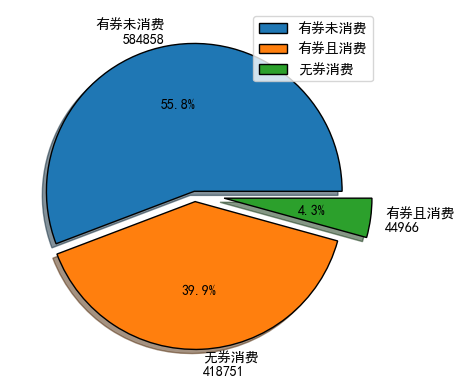

In [13]:
plt.pie([len(cpon_no_consume), len(no_cpon_consume), len(cpon_consume), ], 
        labels=['有券未消费\n{}'.format(len(cpon_no_consume)), 
                '无券消费\n{}'.format(len(no_cpon_consume)), 
                '有券且消费\n{}'.format(len(cpon_consume)),], 
        autopct='%1.1f%%',
        shadow=True,
        wedgeprops={'linewidth': 1, 'edgecolor': 'black'},
        explode=[0.02, 0.05, 0.2],
        )
plt.legend(labels=['有券未消费', '有券且消费', '无券消费'], loc='best')
plt.show()

            2.1.2 有券，距离和优惠折扣力度

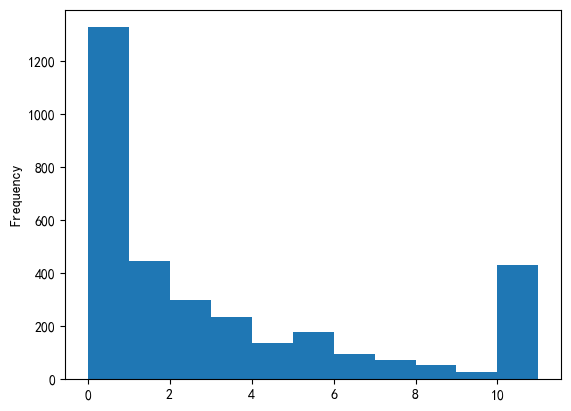

In [14]:
Merchant_distance = cpon_consume.groupby('Merchant_id').Distance.mean()
Merchant_distance.value_counts()
Merchant_distance.plot(kind='hist', bins=11)
plt.show()

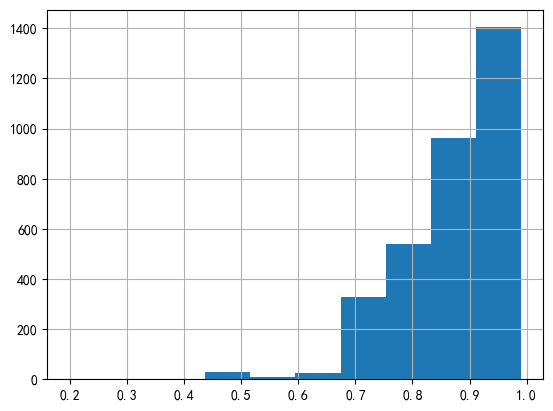

0.882283800869223

In [15]:
Merchant_distance_rate = cpon_consume.groupby('Merchant_id').Discount_rate.mean()
Merchant_distance_rate.sort_values()
Merchant_distance_rate.hist(bins=10)
plt.show()
Merchant_distance_rate.mean() # 所有商家折扣平均值：0.88

            2.1.3 持券到店消费人数最多的商家

In [16]:
cpon_consume

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
6,1439408,2632,8591.0,0.95,0.0,2016-05-16,2016-06-13
33,1113008,1361,11166.0,0.95,0.0,2016-05-15,2016-05-21
38,2881376,8390,7531.0,0.75,0.0,2016-03-21,2016-03-29
69,114747,6901,2366.0,0.83,0.0,2016-05-23,2016-06-05
75,114747,5341,111.0,0.83,0.0,2016-01-27,2016-02-21
...,...,...,...,...,...,...,...
1048424,6068811,2099,12034.0,0.90,3.0,2016-01-25,2016-02-21
1048493,6145611,3381,11951.0,0.90,0.0,2016-01-29,2016-02-21
1048494,6151755,2036,3507.0,0.50,11.0,2016-05-16,2016-05-21
1048517,4854351,3532,883.0,0.90,0.0,2016-02-09,2016-02-28


In [17]:
popular_merchant = cpon_consume.groupby('Merchant_id').User_id.nunique().sort_values(ascending=False)
popular_merchant500 = popular_merchant[popular_merchant > 500]
popular_merchant500.name = 'customer_count'
popular_merchant500

#共有16家店铺，持券消费人数在500人以上
#持券消费人数最多商家是5341，持券消费人数在1652
#排名最后的商家，持券消费人数未502人
#这批商家对优惠券的使用方法得当，消费者喜欢用优惠券进行消费，可以适当借鉴这批商家的推广力度


Merchant_id
5341    1652
760     1527
3381    1274
6485    1198
2099     845
2934     812
450      661
7555     573
3532     559
1520     526
4142     503
6901     502
Name: customer_count, dtype: int64

            2.1.4 持券消费人数在500人以上的商家，连接顾客到店平均距离和平均折扣力度


In [18]:
merge1 = pd.merge(popular_merchant500, Merchant_distance, on='Merchant_id', how='inner')
merchant_pop_dis_rate = pd.merge(merge1, Merchant_distance_rate, on='Merchant_id', how='inner')
merchant_pop_dis_rate

,customer_count,Distance,Discount_rate
Merchant_id,,,
5341,1652,0.394471,0.825942
760,1527,0.850804,0.799251
3381,1274,1.982143,0.747143
6485,1198,1.231687,0.771763
2099,845,1.173700,0.900000
2934,812,2.040201,0.830000
450,661,1.370034,0.819921
7555,573,1.807461,0.828123
3532,559,1.387483,0.852250


            2.1.5 计算到店消费人数与平均距离和折扣力度的相关系数

In [19]:
merchant_pop_dis_rate.corr()
#持券消费人数，与距离和目关，属于生活中的正常现象

,customer_count,Distance,Discount_rate
customer_count,1.000000,-0.316434,-0.593229
Distance,-0.316434,1.000000,0.478608
Discount_rate,-0.593229,0.478608,1.000000


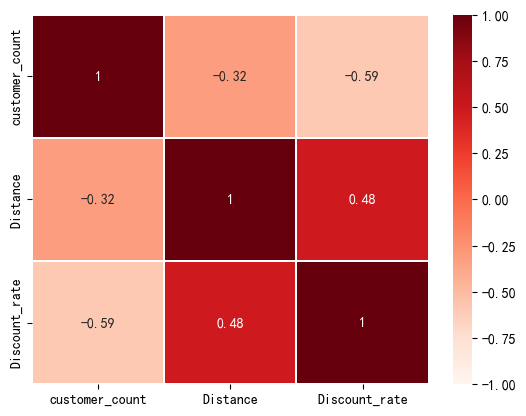

In [20]:
sns.heatmap(merchant_pop_dis_rate.corr(), annot=True, cmap='Reds', vmax=1, vmin=-1, linewidths=0.2)
plt.show()

In [21]:
# 由图可知:  
#1.到店消费人数的多少与顾客到店铺的距离之间呈现负相关，相关系数0.31，在0.3~0.5之间，为低度相关  
#2.到店消费人数的多少与优惠打折力度呈现负相关，相关系数E.2，在0~0.3之间，为相关程度极弱  
#综上所述，这些店家之所以火爆，应该是物美价廉导致，与距离和优惠力度相关性不大  

            2.1.7 分析每天中优惠券的总体发放量与使用量情况

In [22]:
offline.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


In [23]:
offline.Date.notna().sum()

463717

In [24]:
offline.Date_received.notna().sum()

629824

In [25]:
date_sort = offline[offline.Date.notna()].Date.sort_values().unique()
date_sort

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-08T00:00:00.000000000',
       '2016-01-09T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-11T00:00:00.000000000', '2016-01-12T00:00:00.000000000',
       '2016-01-13T00:00:00.000000000', '2016-01-14T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2016-01-16T00:00:00.000000000',
       '2016-01-17T00:00:00.000000000', '2016-01-18T00:00:00.000000000',
       '2016-01-19T00:00:00.000000000', '2016-01-20T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-01-22T00:00:00.000000000',
       '2016-01-23T00:00:00.000000000', '2016-01-24T00:00:00.000000000',
       '2016-01-25T00:00:00.000000000', '2016-01-26T00:00:00.000000000',
       '2016-01-27T00:00:00.000000000', '2016-01-28

In [26]:
date_received_sort = offline[offline.Date_received.notnull()].Date.sort_values().unique()
date_received_sort

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-08T00:00:00.000000000',
       '2016-01-09T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-11T00:00:00.000000000', '2016-01-12T00:00:00.000000000',
       '2016-01-13T00:00:00.000000000', '2016-01-14T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2016-01-16T00:00:00.000000000',
       '2016-01-17T00:00:00.000000000', '2016-01-18T00:00:00.000000000',
       '2016-01-19T00:00:00.000000000', '2016-01-20T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-01-22T00:00:00.000000000',
       '2016-01-23T00:00:00.000000000', '2016-01-24T00:00:00.000000000',
       '2016-01-25T00:00:00.000000000', '2016-01-26T00:00:00.000000000',
       '2016-01-27T00:00:00.000000000', '2016-01-28

In [27]:
consume_num_everday = cpon_consume[['User_id', 'Date_received']]
consume_num_everday = consume_num_everday.groupby('Date_received').count()
consume_num_everday = consume_num_everday.rename(columns={'User_id': 'count'})
consume_num_everday

,count
Date_received,
2016-01-01,48
2016-01-02,43
2016-01-03,49
2016-01-04,60
2016-01-05,68
...,...
2016-06-11,210
2016-06-12,199
2016-06-13,275


In [28]:
date_receive_sort = offline[offline.Date_received.notna()].Date_received.sort_values().unique()
date_receive_sort

array(['2016-01-01T00:00:00.000000000', '2016-01-02T00:00:00.000000000',
       '2016-01-03T00:00:00.000000000', '2016-01-04T00:00:00.000000000',
       '2016-01-05T00:00:00.000000000', '2016-01-06T00:00:00.000000000',
       '2016-01-07T00:00:00.000000000', '2016-01-08T00:00:00.000000000',
       '2016-01-09T00:00:00.000000000', '2016-01-10T00:00:00.000000000',
       '2016-01-11T00:00:00.000000000', '2016-01-12T00:00:00.000000000',
       '2016-01-13T00:00:00.000000000', '2016-01-14T00:00:00.000000000',
       '2016-01-15T00:00:00.000000000', '2016-01-16T00:00:00.000000000',
       '2016-01-17T00:00:00.000000000', '2016-01-18T00:00:00.000000000',
       '2016-01-19T00:00:00.000000000', '2016-01-20T00:00:00.000000000',
       '2016-01-21T00:00:00.000000000', '2016-01-22T00:00:00.000000000',
       '2016-01-23T00:00:00.000000000', '2016-01-24T00:00:00.000000000',
       '2016-01-25T00:00:00.000000000', '2016-01-26T00:00:00.000000000',
       '2016-01-27T00:00:00.000000000', '2016-01-28

In [29]:
coupon_sendout_everday = offline[offline.Date_received.notna()][['Date_received', 'User_id']]
coupon_sendout_everday = coupon_sendout_everday.groupby('Date_received').count()
coupon_sendout_everday = coupon_sendout_everday.rename(columns={'User_id': 'count'})
coupon_sendout_everday

,count
Date_received,
2016-01-01,340
2016-01-02,334
2016-01-03,341
2016-01-04,337
2016-01-05,396
...,...
2016-06-11,3087
2016-06-12,2412
2016-06-13,4740


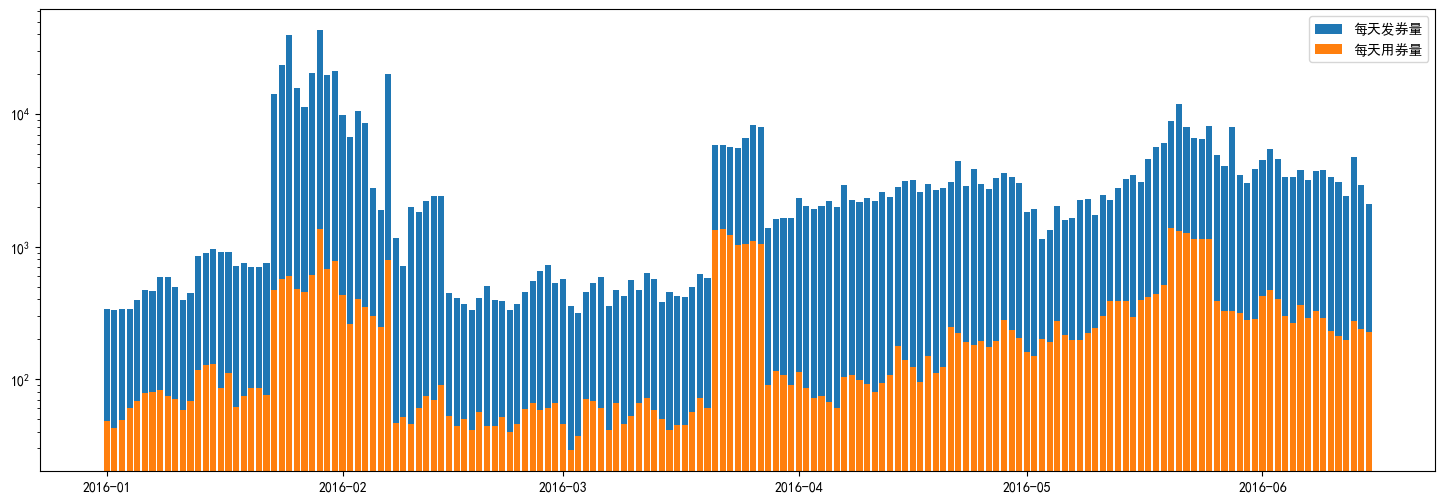

In [30]:
plt.figure(figsize=(18, 6))
plt.bar(date_receive_sort, coupon_sendout_everday['count'], label='每天发券量')
plt.bar(date_receive_sort, consume_num_everday['count'], label='每天用券量')
plt.yscale('log')
plt.legend()
plt.show()
#16年2月为例，用券量级别再1000，发券量再10万左右，在100倍左右，优惠券的使用率还是非常低的

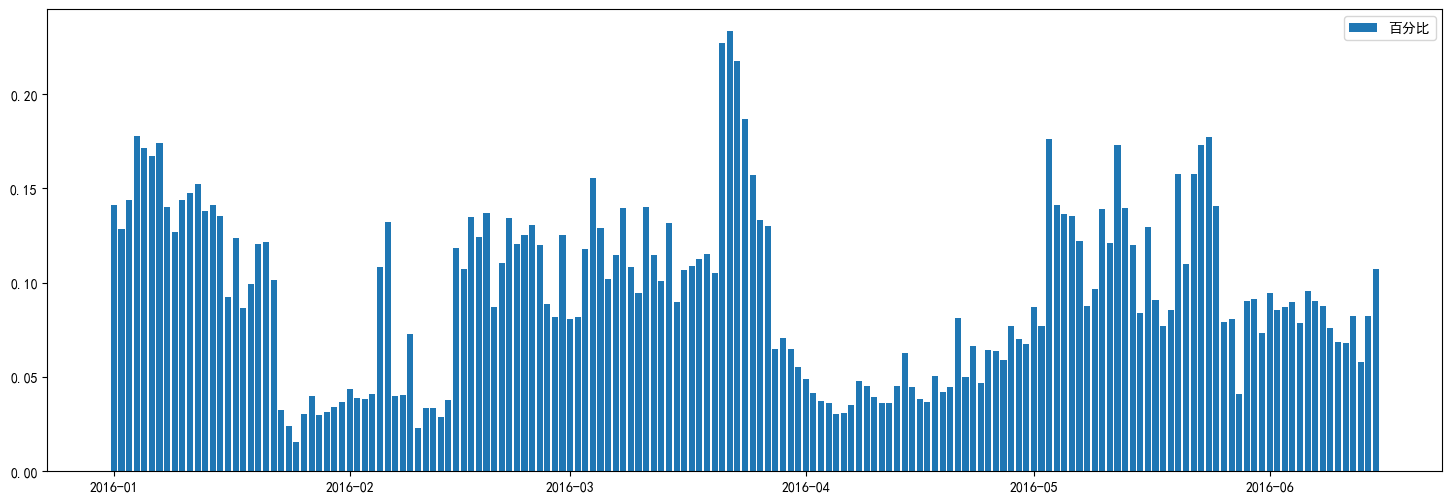

In [31]:
plt.figure(figsize=(18, 6))
plt.bar(date_receive_sort,
        consume_num_everday['count']/coupon_sendout_everday['count'], 
        label='百分比')
plt.legend()
plt.show()


In [32]:
#由图可知，优惠券使用率最高在16年书3月底，达到了30%
#使用率最低在16年1月底，最低为3%左右。
#整体来看，优惠券使用率波动较大。

## 三. 总体情况统计分析



        3.1 数据总体情况 

In [33]:
offline.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaT,2016-02-17
1,1439408,4663,11002.0,0.87,1.0,2016-05-28,NaT
2,1439408,2632,8591.0,0.95,0.0,2016-02-17,NaT
3,1439408,2632,1078.0,0.95,0.0,2016-03-19,NaT
4,1439408,2632,8591.0,0.95,0.0,2016-06-13,NaT


In [34]:
# 不使用科学记数法
pd.set_option('display.float_format', lambda x: '%.4f' % x)
offline.Coupon_id.notna().sum()
print(f'领券人数：{offline.Coupon_id.notna().sum()}')

领券人数：629824


In [35]:
cpon_consume = offline[offline.Coupon_id.notna() & offline.Date.notna()]
len(cpon_consume)
print(f'有券且消费人数：{len(cpon_consume)}')

有券且消费人数：44966


In [36]:
len(cpon_consume) / offline.Coupon_id.notna().sum() * 100
print(f'核销率：{len(cpon_consume) / offline.Coupon_id.notna().sum() * 100:.2f}%')

核销率：7.14%


        3.2 优惠券每月核销情况统计

In [37]:
offline['month'] = offline.Date.dt.month
offline


,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,month
0,1439408,2632,NaN,NaN,0.0000,NaT,2016-02-17,2.0000
1,1439408,4663,11002.0000,0.8700,1.0000,2016-05-28,NaT,NaN
2,1439408,2632,8591.0000,0.9500,0.0000,2016-02-17,NaT,NaN
3,1439408,2632,1078.0000,0.9500,0.0000,2016-03-19,NaT,NaN
4,1439408,2632,8591.0000,0.9500,0.0000,2016-06-13,NaT,NaN
...,...,...,...,...,...,...,...,...
1048570,5186127,4043,3996.0000,0.8300,1.0000,2016-02-03,2016-02-10,2.0000
1048571,5186127,4043,3996.0000,0.8300,1.0000,2016-02-12,NaT,NaN
1048572,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-30,5.0000
1048573,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-01,5.0000


In [38]:
offline.groupby('month')['Coupon_id'].count() / offline.groupby('month')['Date'].count() * 100

for i in range(1, 7):
    print(
        f'{i}月核销率：{(offline.groupby("month")["Coupon_id"].count() / offline.groupby("month")["Date"].count() * 100)[i]:.2f}%')


1月核销率：6.14%
2月核销率：16.56%
3月核销率：8.36%
4月核销率：6.84%
5月核销率：11.14%
6月核销率：10.47%


        3.3 每月新增用户数

In [39]:
cpon_consume['month'] = cpon_consume.Date.dt.month
cpon_consume.groupby('month').User_id.nunique()

for i in range(1, 7):
    print(f'{i}月新增人数：{cpon_consume.groupby("month").User_id.nunique()[i]}人')

1月新增人数：2691人
2月新增人数：5352人
3月新增人数：5407人
4月新增人数：4079人
5月新增人数：8550人
6月新增人数：6601人


C:\Users\wdl\AppData\Local\Temp\ipykernel_4552\1011993814.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpon_consume['month'] = cpon_consume.Date.dt.month


## 四. 用户分析


        4.1 获客：每日新增用户情况

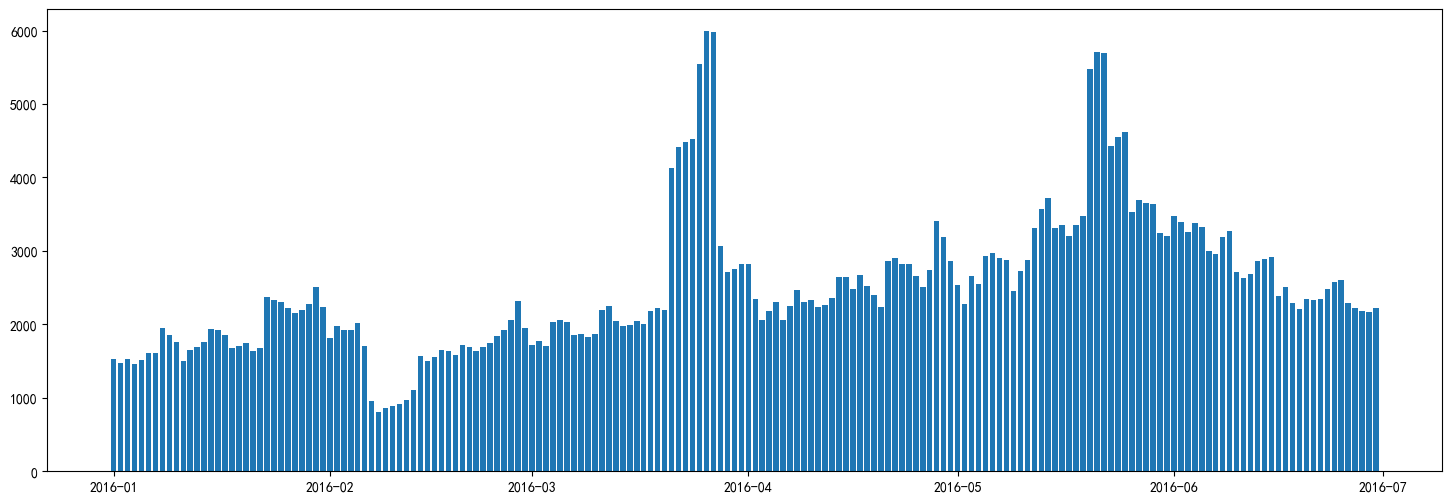

In [40]:
new_user_everyday = offline[offline.Date.notna()].groupby('Date').User_id.nunique()
plt.figure(figsize=(18, 6))
plt.bar(new_user_everyday.index, new_user_everyday.values)
plt.show()

        4.2 转化及流失情况

In [41]:
cpon_user = offline[offline.Date.notna()].groupby('User_id').count()
cpon_user.Date[cpon_user.Date == 1].sum()
print(f'只消费一次的用户数：{cpon_user.Date[cpon_user.Date == 1].sum()}')

只消费一次的用户数：61765


In [42]:
cpon_user.Date[cpon_user.Date == 1].sum() / offline.User_id.nunique() * 100
print(f'只消费一次的用户占比：{cpon_user.Date[cpon_user.Date == 1].sum() / offline.User_id.nunique() * 100:.2f}%')

只消费一次的用户占比：19.12%


        4.3 用户行为转化漏斗计算

In [43]:
offline.head(5)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,month
0,1439408,2632,NaN,NaN,0.0000,NaT,2016-02-17,2.0000
1,1439408,4663,11002.0000,0.8700,1.0000,2016-05-28,NaT,NaN
2,1439408,2632,8591.0000,0.9500,0.0000,2016-02-17,NaT,NaN
3,1439408,2632,1078.0000,0.9500,0.0000,2016-03-19,NaT,NaN
4,1439408,2632,8591.0000,0.9500,0.0000,2016-06-13,NaT,NaN


In [44]:
offline.User_id.count()

1048575

In [45]:
offline.Coupon_id.count() / offline.User_id.count() * 100
print(f'领券总人数：{offline.Coupon_id.count() / offline.User_id.count() * 100:.2f}%')

领券总人数：60.06%


In [46]:
cpon_consume.User_id.count() / offline.User_id.count() * 100
print(f'领券且消费人数：{cpon_consume.User_id.count() / offline.User_id.count() * 100:.2f}%')

领券且消费人数：4.29%


        4.4 用户留存情况

        4.5 用户价值分析  
        
            4.5.1 先查询用户最近的消费时间间隔及消费频次

In [47]:
temp_df = offline[offline.Date.notna()]
temp_df 

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,month
0,1439408,2632,NaN,NaN,0.0000,NaT,2016-02-17,2.0000
5,1439408,2632,NaN,NaN,0.0000,NaT,2016-05-16,5.0000
6,1439408,2632,8591.0000,0.9500,0.0000,2016-05-16,2016-06-13,6.0000
11,2029232,6459,NaN,NaN,0.0000,NaT,2016-06-26,6.0000
12,2029232,6459,NaN,NaN,0.0000,NaT,2016-05-19,5.0000
...,...,...,...,...,...,...,...,...
1048569,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-28,5.0000
1048570,5186127,4043,3996.0000,0.8300,1.0000,2016-02-03,2016-02-10,2.0000
1048572,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-30,5.0000
1048573,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-01,5.0000


In [48]:
rfm_df = temp_df.groupby('User_id').Date.max() # 每个用户最后一次消费时间
rfm_df = pd.DataFrame(rfm_df)
rfm_df.head(3)

,Date
User_id,
165,2016-06-17
184,2016-02-28
316,2016-06-19


In [49]:
rfm_df['count'] = temp_df.groupby('User_id').Date.count() # 每个用户消费次数
rfm_df.head(3)

,Date,count
User_id,,
165,2016-06-17,14
184,2016-02-28,1
316,2016-06-19,7


            4.5.2 分别查询R,F的最大值，最小值以及各值数量分布情况

In [50]:
rfm_df['R'] = (datetime(2016, 6, 30) - temp_df.groupby('User_id').Date.max()).dt.days # 最后一次消费时间距离观测窗口结束的天数
rfm_df.head(3)

,Date,count,R
User_id,,,
165,2016-06-17,14,13
184,2016-02-28,1,123
316,2016-06-19,7,11


In [51]:
rfm_df['F'] = temp_df.groupby('User_id').Date.count() # 每个用户消费次数
rfm_df.head(3)

,Date,count,R,F
User_id,,,,
165,2016-06-17,14,13,14
184,2016-02-28,1,123,1
316,2016-06-19,7,11,7


In [52]:
rfm_df.R.describe()

count   130087.0000
mean        60.2416
std         47.8036
min          0.0000
25%         22.0000
50%         44.0000
75%         95.0000
max        181.0000
Name: R, dtype: float64

In [53]:
rfm_df.F.describe()

count   130087.0000
mean         3.5647
std          5.6440
min          1.0000
25%          1.0000
50%          2.0000
75%          4.0000
max        196.0000
Name: F, dtype: float64

            4.5.3 根据R,F值最大值和最小值的区间设计本次的打分标准，计算R,F的值

In [54]:
def get_R(x):
    if x <= 30:
        return 4
    elif x <= 60:
        return 3
    elif x <= 90:
        return 2
    else:
        return 1
    
rfm_df['R_score'] = rfm_df.R.apply(get_R)
rfm_df.head(3)

,Date,count,R,F,R_score
User_id,,,,,
165,2016-06-17,14,13,14,4
184,2016-02-28,1,123,1,1
316,2016-06-19,7,11,7,4


In [55]:
def get_F(x):
    if x <= 1:
        return 1
    elif x <= 2:
        return 2
    elif x <= 3:
        return 3
    elif x <= 4:
        return 4
    else:
        return 5
    
rfm_df['F_score'] = rfm_df.F.apply(get_F)
rfm_df.head(3)

,Date,count,R,F,R_score,F_score
User_id,,,,,,
165,2016-06-17,14,13,14,4,5
184,2016-02-28,1,123,1,1,1
316,2016-06-19,7,11,7,4,5


            4.5.4 查询R,F值的平均值

In [56]:
rfm_df[['R_score', 'F_score']] = (rfm_df[['R_score', 'F_score']] - rfm_df[['R_score', 'F_score']].mean()).applymap(lambda x: '1' if x > 
                                                                                                                   0 else '0')
rfm_df

,Date,count,R,F,R_score,F_score
User_id,,,,,,
165,2016-06-17,14,13,14,1,1
184,2016-02-28,1,123,1,0,0
316,2016-06-19,7,11,7,1,1
448,2016-06-30,14,0,14,1,1
452,2016-05-21,2,40,2,1,0
...,...,...,...,...,...,...
7360556,2016-05-15,3,46,3,1,1
7360651,2016-06-13,5,17,5,1,1
7360675,2016-06-17,2,13,2,1,0


            4.5.5 根据平均值和用户分类规则表对用户分类

In [57]:
def label(x):
    d = {'11': '重要价值客户',
         '10': '重要发展客户',
         '01': '重要保持客户',
         '00': '重要挽留客户'}
    level = x['R_score'] + x['F_score']
    return d[level]

rfm_df['label'] = rfm_df.apply(label, axis=1)
rfm_df.label.value_counts()

重要挽留客户    44255
重要发展客户    39999
重要价值客户    37948
重要保持客户     7885
Name: label, dtype: int64

            4.5.6 查询各分层用户数量

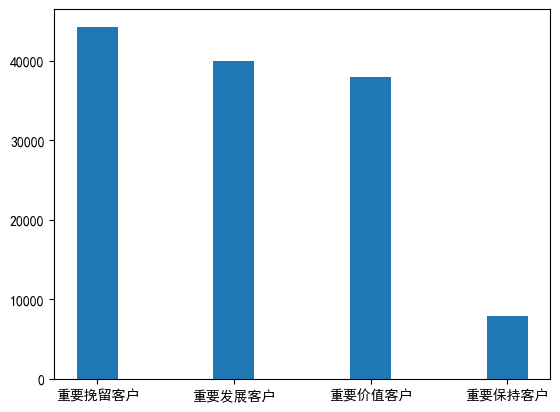

In [58]:
plt.bar(rfm_df.label.value_counts().index, rfm_df.label.value_counts().values, width=0.3)
plt.show()

## 五. 商户分析



        5.1 每月有消费商户统计

In [59]:
temp_df2 = offline[offline.Date.notna()]
temp_df2.drop('month', axis=1, inplace=True)
temp_df2['month'] = temp_df2.Date.dt.month
temp_df2.groupby('month').Merchant_id.nunique()

C:\Users\wdl\AppData\Local\Temp\ipykernel_4552\2049594753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2.drop('month', axis=1, inplace=True)
C:\Users\wdl\AppData\Local\Temp\ipykernel_4552\2049594753.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2['month'] = temp_df2.Date.dt.month


month
1    2711
2    2423
3    4029
4    5251
5    6584
6    5598
Name: Merchant_id, dtype: int64

In [60]:
for i in range(1, 7):
    print(f'{i}月商家数量：{temp_df2.groupby("month").Merchant_id.nunique()[i]}个')

1月商家数量：2711个
2月商家数量：2423个
3月商家数量：4029个
4月商家数量：5251个
5月商家数量：6584个
6月商家数量：5598个


        5.2 一周内每天有消费的商户数量

In [61]:
temp_df2['weekday'] = temp_df2.Date.dt.weekday + 1
temp_df2.groupby('weekday').Merchant_id.nunique()

C:\Users\wdl\AppData\Local\Temp\ipykernel_4552\2856122812.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df2['weekday'] = temp_df2.Date.dt.weekday + 1


weekday
1    5085
2    5135
3    5220
4    5387
5    5444
6    5506
7    5276
Name: Merchant_id, dtype: int64

In [62]:
for i in range(1, 8):
    print(f'星期{i}有消费的商家数量：{temp_df2.groupby("weekday").Merchant_id.nunique()[i]}个')

星期1有消费的商家数量：5085个
星期2有消费的商家数量：5135个
星期3有消费的商家数量：5220个
星期4有消费的商家数量：5387个
星期5有消费的商家数量：5444个
星期6有消费的商家数量：5506个
星期7有消费的商家数量：5276个


        5.3 商户整体核销率，核销率在0.25以下的商户占比

In [63]:
temp_df2

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,month,weekday
0,1439408,2632,NaN,NaN,0.0000,NaT,2016-02-17,2,3
5,1439408,2632,NaN,NaN,0.0000,NaT,2016-05-16,5,1
6,1439408,2632,8591.0000,0.9500,0.0000,2016-05-16,2016-06-13,6,1
11,2029232,6459,NaN,NaN,0.0000,NaT,2016-06-26,6,7
12,2029232,6459,NaN,NaN,0.0000,NaT,2016-05-19,5,4
...,...,...,...,...,...,...,...,...,...
1048569,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-28,5,6
1048570,5186127,4043,3996.0000,0.8300,1.0000,2016-02-03,2016-02-10,2,3
1048572,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-30,5,1
1048573,5186127,4043,NaN,NaN,1.0000,NaT,2016-05-01,5,7


In [64]:
temp_df2[temp_df2.Date_received.notna() & temp_df2.Date.notna()].Date.count() / temp_df2.Date.count()
print(f'商户整体核销率：{temp_df2[temp_df2.Date_received.notna() & temp_df2.Date.notna()].Date.count() / temp_df2.Date.count()*100:.2f}%')

商户整体核销率：9.70%


In [65]:
Merchan_write_off_rate = temp_df2[temp_df2.Date_received.notna() & temp_df2.Date.notna()].groupby('Merchant_id').Date.count() / temp_df2.groupby('Merchant_id').Date.count()
Merchan_write_off_rate[Merchan_write_off_rate < 0.25].count() / Merchan_write_off_rate.count() * 100
print(f'核销率低于25%的商户占比：{Merchan_write_off_rate[Merchan_write_off_rate < 0.25].count() / Merchan_write_off_rate.count() * 100:.2f}%')

核销率低于25%的商户占比：77.15%


        5.4 商户分层

In [74]:
offline[offline.Coupon_id.notna()]

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,month
1,1439408,4663,11002.0000,0.8700,1.0000,2016-05-28,NaT,NaN
2,1439408,2632,8591.0000,0.9500,0.0000,2016-02-17,NaT,NaN
3,1439408,2632,1078.0000,0.9500,0.0000,2016-03-19,NaT,NaN
4,1439408,2632,8591.0000,0.9500,0.0000,2016-06-13,NaT,NaN
6,1439408,2632,8591.0000,0.9500,0.0000,2016-05-16,2016-06-13,6.0000
...,...,...,...,...,...,...,...,...
1048566,4384335,3381,9776.0000,0.5000,11.0000,2016-01-29,NaT,NaN
1048567,4384335,3381,1807.0000,0.9000,11.0000,2016-01-28,NaT,NaN
1048568,4912719,450,8555.0000,0.8300,3.0000,2016-02-04,NaT,NaN
1048570,5186127,4043,3996.0000,0.8300,1.0000,2016-02-03,2016-02-10,2.0000


In [78]:
temp_df3 = offline[offline.Coupon_id.notna()].groupby('Merchant_id')
temp_df3

In [83]:
temp_df3.Date.count()[temp_df3.Date.count() > 100].count()

61

In [93]:
temp_df3.Date.count() < 100

Merchant_id
2       True
3       True
4       True
5       True
8       True
        ... 
8848    True
8850    True
8852    True
8854    True
8856    True
Name: Date, Length: 5347, dtype: bool

## 六. 优惠券分析

        6.1 优惠券每日领取，每日核销情况

        6.2 优惠券平均核销时间

        6.3 不同距离下优惠券的领取量及核销率

## 七.  相关分析
        7.1 门店距离与优惠券核销率的相关性

        7.2 优惠券折扣与核销率的相关性

## 八. Tableau可视化图表

## 九. 数据分析